## Balanced cycle separators in planar graphs

Let $G$ be a planar triangulation and let $w: F \to \mathbb{R}^+$ be face weight such that $\sum w = 1$ and $w(f) \leq 1/4$ for each face $f$. We would like to find a cycle $C$ in $G$ with property:
$$
\sum_{f \in Int(C)} w(f) \leq 3/4\qquad and \qquad \sum_{f\in Ext(C)} w(f) \leq 3/4
$$
where $Int(C)$ and $Ext(C)$ are interior and exterior faces with respect to the cycle $C$.

Steps are
1. Let $T$ be a tree with $\Delta(T) \leq 3$ and let $w: V(T) \to \mathbb{R}^+$ be vertex weight function with $\sum w = 1$ such that $w(v) \leq 1/4$ for each vertex $v$. Then there exist an edge $e$ such that $T - e = T_1 \cup T_2$ and $w(T_1) \leq 3/4$ and $w(T_2) \leq 3/4$. <br/>
The function `tree_weight_decomposition(T, w)` is already implemented below.

2. Choose a cycle $C_\infty$ to be the infinite cycle (outer face) and use modified BFS algorithm to find a BFS tree from $C_\infty$ and to determine distance $dist(v)$ from $C_\infty$ for each vertex $v \in V(G)$.

3. Find dual tree $T^*$ of the BFS tree $T$. Vertices of $T^*$ are faces of $G$ and two faces are connected if they are adjacent and the edge between them is not in $T$. 

4. Use algorithm from Step 1 to find edge $e^* = (f, g)$ in $T^*$.

5. Find edge $e$ in $G$ which is common edge of faces $f$ and $g$. Then there is a cycle in $T \cup e$. This cycle $C$ is a solution of the algorithm.

#### BFS from set S

In [20]:
def BFS(G, S):
    import queue
    
    prev = {}
    dist = {}
    q = queue.Queue()
    for s in S:
        prev[s] = None
        dist[s] = 0
        q.put(s)
    while not q.empty():
        v = q.get()
        for u in G.neighbors(v):
            if u not in prev:
                prev[u] = v
                dist[u] = dist[v] + 1
                q.put(u)
    return prev, dist

def face_edges_to_tuple(F):
    return tuple([u for (u, v) in F])

def tuple_to_face_edges(T):
    """Convert a tuple (a1, a2, ..., ak) representing a face to 
    a list of 'edges' [(a1, a2), (a2, a3), ..., (ak, a1)] """
    f = []
    for i in range(len(T)):
        f.append((T[i], T[(i + 1) % len(T)]))
    return f

def face(G):
    """Find one face (sequence of vertices on it); call after embedding is set
    """
    return [a for (a, b) in G.faces()[0]]    

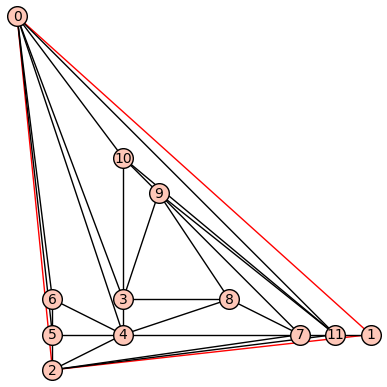

In [21]:
G = Graph('K{mkXOXC[_{J')  # Planar triangulation
G.is_planar(set_embedding=True, set_pos=True)  # find planar embedding
Tr = face(G)  # take the first triangle to be our "initial" triangle
G.plot(edge_colors={"red": tuple_to_face_edges(Tr)})

### Step 1

In [22]:
def tree_weight_decomposition(T, w):
    """
    Arguments
    T tree, Delta(T) <= 3
    w weights, w: V(T) -> R+, sum w(v) = 1, w(v) <= 1/4
    
    Result is edge e = (u, v) such that G = T1 + e + T2 and 
    w(T1) <= 3/4, w(T2) <= 3/4
    Algorithm should be linear in the number of vertices (edges)
    """
    # See:
    # https://planarity.org/Klein_rooted_forests_and_trees.pdf
    # Lemma 1.3.2 
    # Or:
    # Let eweights[(u, v)] be a weight of the component of T - (u, v) containing u
    # Calculate eweights[(u, v)] for each (directed) edge (u, v). You can do this recursively.
    # Find edge e = (u, v) for which difference abs(eweights[(u, v)] - ewighths[(v, u)]) is minimal and return e
    eweights = {}   
    mindif = None
    e = None
    for u, v in T.edges(labels = False, sort=False):
        wuv = edge_weight_memo(eweights, T, w, (u, v))
        wvu = edge_weight_memo(eweights, T, w, (v, u))
        if mindif == None or abs(wuv - wvu) < mindif:
            mindif = abs(wuv - wvu)
            e = (u, v)
    return e
    
def edge_weight_memo(eweights, T, w, e):
    (u, v) = e
    if (u, v) in eweights:
        return eweights[(u, v)]
    else:
        weight = w[u]
        for x in T.neighbors(u):
            if x != v:
                weight += edge_weight_memo(eweights, T, w, (x, u))
        eweights[(u, v)] = weight
        return weight

#### Test of Step 1

In [23]:
def random_binary_tree_rec(depth):
    if depth == 0:
        return Graph({0: []}), 0
    rand = randint(0, 2)
    T1, root1 = random_binary_tree_rec(depth - 1)
    if rand == 0:
        return T1, root1
    n1 = T1.num_verts()
    T2, root2 = random_binary_tree_rec(depth - 1)
    n2 = T2.num_verts()
    T2.relabel(dict((v, i + n1) for i, v in enumerate(T2.vertices(sort=False))))
    T = T1.union(T2)
    n = n1 + n2
    T.add_vertex(n)
    T.add_edges([(root1, n), (root2 + n1, n)])
    return T, n
    
def random_binary_tree(depth):
    T, _ = random_binary_tree_rec(depth)
    return T

def random_binary_tree_w(depth):
    T, _ = random_binary_tree_rec(depth)
    w = [random() for _ in range(T.num_verts())]
    sw = sum(w)
    wd = dict((v, w[i]/sw) for i, v in enumerate(T.vertices(sort=False)))
    return T, wd

def weight(T, w):
    return sum([w[v] for v in T])

def test_tree_weight_decomposition(T, w):
    TT = T.copy()
    a, b = tree_weight_decomposition(TT, w)    
    TT.delete_edge((a, b))
    [S1, S2] = TT.connected_components_subgraphs()
    return weight(S1, w), weight(S2, w),

def test_tree_weight_decomposition1(T, w):
    TT = T.copy()
    a, b = tree_weight_decomposition1(TT, w)    
    TT.delete_edge((a, b))
    [S1, S2] = TT.connected_components_subgraphs()
    return weight(S1, w), weight(S2, w),

In [24]:
RT, w = random_binary_tree_w(7)

In [25]:
tree_weight_decomposition(RT, w)

(76, 136)

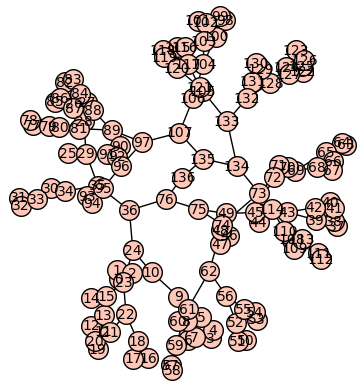

In [26]:
RT.plot()

In [27]:
test_tree_weight_decomposition(RT, w)

(0.5713568162079161, 0.4286431837920834)

### Step 2

In [28]:
def BFS_graph(G, S):
    """
    G: triangulation, 
    S: 'outer' face
    result is pair (T, dist) where is 'tree' from S together with edges of S 
    and dist is distance map from S
    """
    prev, dist = BFS(G, S)
    edges = [(u, v) for (u, v) in prev.items() if v != None]
    edges.extend(tuple_to_face_edges(S))
    return Graph(edges), dist

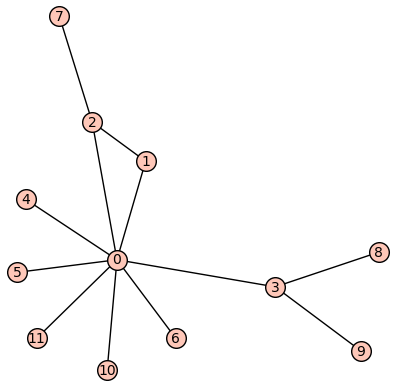

In [29]:
BFS_graph(G, Tr)[0].plot()

In [30]:
BFS_graph(G, Tr)[1]

{0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1, 10: 1, 11: 1, 7: 1, 8: 2, 9: 2}

Explanation: dictionary above gives the distances for each vertex from the outer triangle 

In [31]:
Tr

[0, 1, 2]

### Step 3

clean_face_edges [(0, 1), (1, 2), (2, 0)]
u 1 v 11
clean_face_edges [(0, 2), (2, 5), (5, 0)]
u 1 v 11
clean_face_edges [(0, 3), (3, 10), (10, 0)]
u 1 v 11
clean_face_edges [(0, 4), (4, 3), (3, 0)]
u 1 v 11
clean_face_edges [(0, 5), (5, 6), (6, 0)]
u 1 v 11
clean_face_edges [(0, 6), (6, 4), (4, 0)]
u 1 v 11
clean_face_edges [(0, 10), (10, 11), (11, 0)]
u 1 v 11
clean_face_edges [(0, 11), (11, 1), (1, 0)]
u 1 v 11
clean_face_edges [(1, 11), (11, 2), (2, 1)]
u 1 v 11
clean_face_edges [(2, 4), (4, 5), (5, 2)]
u 1 v 11
clean_face_edges [(2, 7), (7, 4), (4, 2)]
u 1 v 11
clean_face_edges [(2, 11), (11, 7), (7, 2)]
u 1 v 11
clean_face_edges [(3, 4), (4, 8), (8, 3)]
u 1 v 11
clean_face_edges [(3, 8), (8, 9), (9, 3)]
u 1 v 11
clean_face_edges [(3, 9), (9, 10), (10, 3)]
u 1 v 11
clean_face_edges [(4, 6), (6, 5), (5, 4)]
u 1 v 11
clean_face_edges [(4, 7), (7, 8), (8, 4)]
u 1 v 11
clean_face_edges [(7, 9), (9, 8), (8, 7)]
u 1 v 11
clean_face_edges [(7, 11), (11, 9), (9, 7)]
u 1 v 11
clean_face_edge

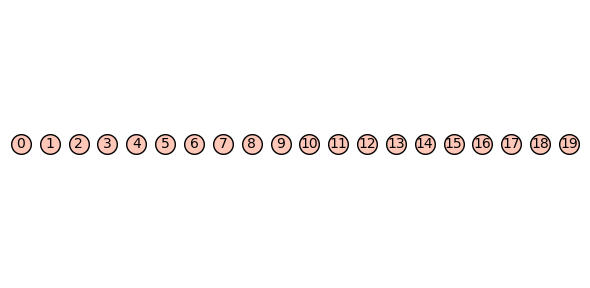

In [ ]:
def dual_tree(G, T):
    """Step 3 of the algorithm. Find dual tree. BFSG is the (first) result of the BFS_graph function above
    """
    # Get all faces of G
    faces = G.faces()
    
    # Create a new graph for the dual tree
    T_star = Graph()
    
    # Add all faces as vertices to T*
    for i, face in enumerate(faces):
        T_star.add_vertex(i)
    
    # For each edge in G that is not in T
    for u, v in G.edges(labels=False):
        if not T.has_edge(u, v):
            # Find the two faces that share this edge
            face1 = None
            face2 = None
            for face in faces:
                face_edges = tuple_to_face_edges(face)
                clean_face_edges = [e[0] for e in face_edges]
                if (u, v) in clean_face_edges or (v, u) in clean_face_edges:
                    if face1 is None:
                        face1 = i
                    else:
                        face2 = i
                        break
            
            # Add edge between these faces in T*
            print("face1", face1, "face2", face2)
            if face1 is not None and face2 is not None:
                T_star.add_edge(face1, face2)
    
    return T_star
dual_tree(G, BFS_graph(G, Tr)[0]).plot()

In [33]:
dual_tree(G, BFS_graph(G, Tr)[0])

Graph on 20 vertices (use the .plot() method to plot)

In [34]:
dual_tree(G, BFS_graph(G, Tr)[0]).vertices()

[((0, 1), (1, 2), (2, 0)),
 ((0, 2), (2, 5), (5, 0)),
 ((0, 3), (3, 10), (10, 0)),
 ((0, 4), (4, 3), (3, 0)),
 ((0, 5), (5, 6), (6, 0)),
 ((0, 6), (6, 4), (4, 0)),
 ((0, 10), (10, 11), (11, 0)),
 ((0, 11), (11, 1), (1, 0)),
 ((1, 11), (11, 2), (2, 1)),
 ((2, 4), (4, 5), (5, 2)),
 ((2, 7), (7, 4), (4, 2)),
 ((2, 11), (11, 7), (7, 2)),
 ((3, 4), (4, 8), (8, 3)),
 ((3, 8), (8, 9), (9, 3)),
 ((3, 9), (9, 10), (10, 3)),
 ((4, 6), (6, 5), (5, 4)),
 ((4, 7), (7, 8), (8, 4)),
 ((7, 9), (9, 8), (8, 7)),
 ((7, 11), (11, 9), (9, 7)),
 ((9, 11), (11, 10), (10, 9))]

Explanation: Vertices of this graph are faces of the triangulation (except of outer face (0, 1, 2)). Two vertices (faces) are connected precisely when the faces are adjacent and the edge between the two faces is *not* in the BFSG.
For example, faces (0, 3, 10) and (10, 11, 0) are not connected since the edge between them (0, 10) is in the BFSG (see image above), while there is an edge between (0, 3, 10) and (3, 0, 4) since the edge between them (0, 3) is not in BFSG.

### Put everything together

In [35]:
def find_cycle_separator(G, S, w):
    BT, dist = BFS_graph(G, Tr)
    DT = dual_tree(G, BT)
    
    # Find edge in dual tree
    # ...
    
    # Find edge in BFS tree
    # ...
    
    # Create cycle C
    # ...
        
    return C

### Test and plot solution

In [36]:
# make uniform weights
w = dict([(face_edges_to_tuple(f), 1/len(G.faces())) for f in G.faces()])
C = find_cycle_separator(G, Tr, w)

NameError: name 'C' is not defined

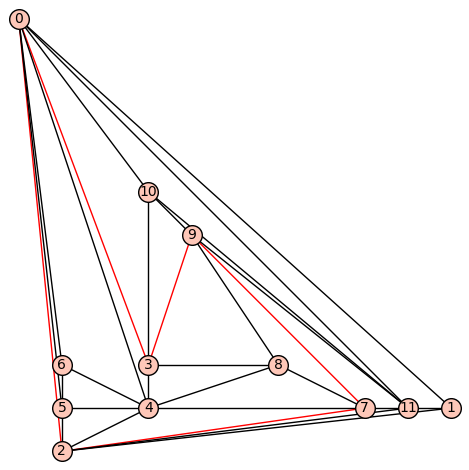

In [ ]:
G.plot(edge_colors={"red": tuple_to_face_edges(C)})

In [ ]:
C

[7, 2, 0, 3, 9]

Explanation; the number (since we use uniform weights) of triangles inside and outside red cycle is "balanced", i.e., <= 3/4 of the total number of triangles. 

#### Further tests

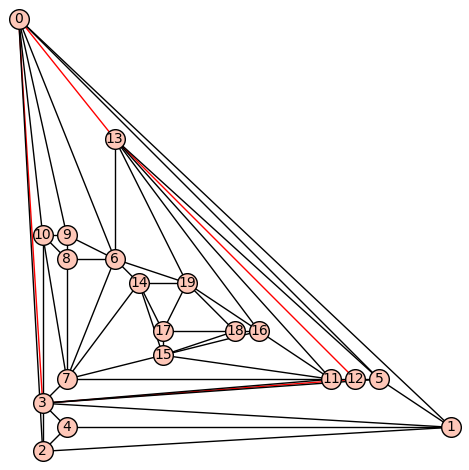

In [ ]:
G =  Graph('S~^S?cB_kbaGD@``_W?AH?@S??o??wCB[')
G.is_planar(set_embedding=True, set_pos=True) 
w = dict([(face_edges_to_tuple(f), 1/len(G.faces())) for f in G.faces()])
Tr = face(G)
C = find_cycle_separator(G, Tr, w)
G.plot(edge_colors={"red": tuple_to_face_edges(C)})

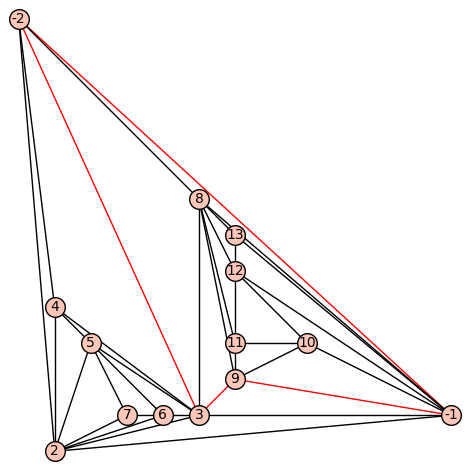

In [ ]:
G =  graphs.RandomTriangulation(14) # Graph('S~^S?cB_kbaGD@``_W?AH?@S??o??wCB[') # graphs.RandomTriangulation(12)
G.is_planar(set_embedding=True, set_pos=True) 
w = dict([(face_edges_to_tuple(f), 1/len(G.faces())) for f in G.faces()])
Tr = face(G)
C = find_cycle_separator(G, Tr, w)
G.plot(edge_colors={"red": tuple_to_face_edges(C)})